In [1]:
import pytreenet as ptn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy , copy

In [2]:
r

NameError: name 'r' is not defined

# Exact (Qutip)

In [10]:
# System initialization
t = 2
u = 0.1
mu = 0.5
Lx = 4
Ly = 4
n_bosons = 2
system = ptn.BoseHubbard2D_Qutip(Lx, Ly, n_bosons, t, u, mu)

# Create initial state
black_state = np.array([0,1])
white_state = np.array([1,0])
psi0 = system.alternating_product_state(black_state, white_state, pattern= "checkerboard")
#psi0 = system.uniform_product_state([1/np.sqrt(2), 1/np.sqrt(2)])
# Evolve system
end_time = 2
dt = 0.01
result = system.evolve_system(psi0, end_time=end_time, dt=dt)


# 2TDVP on MPS (TenPy)

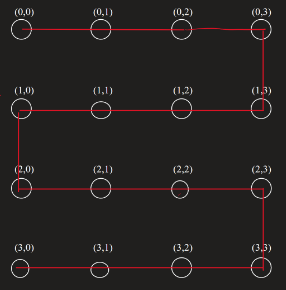

In [ ]:
# Set up parameters
Lx = 4
Ly = 4
n_bosons = 2
t = 2
U = 0.1
mu = 0.5

# Create model and initial state
model = ptn.BoseHubbard2D_Tenpy(Lx, Ly, n_bosons, t, U, mu)
black_state = [0, 1]  # |0>
white_state = [1, 0]  # |1>
mps = model.alternating_product_state_custom(black_state, white_state, pattern="checkerboard")

# Print initial state energy
print("Initial energy:", model.H_MPO.expectation_value(mps))

# Print initial occupation for a few sites
print("Initial occupations:")
occ_initial = model.calculate_occupation(mps)
print(occ_initial)  # Print first 2x2 corner

# Evolution parameters
lanczos_params = {
    'N_min': 2,           # Min number of Lanczos steps per /5
    'N_max': 20,          # Max number of Lanczos steps per evolution step/20
    'P_tol': 1e-6,       # Tolerance for convergence in Lanczos /1e-14
    'reortho': False}     # Reorthogonalize vectors in the Krylov space /False
   

# Evolve the state
psi_evolved = model.evolve_system_two_site(mps, 
                                           end_time = 2,
                                           dt = 0.01, 
                                           chi_max = 80, 
                                           svd_min = 1e-3, 
                                           lanczos_params=lanczos_params) 

# TDVP 

# Spanning Tree

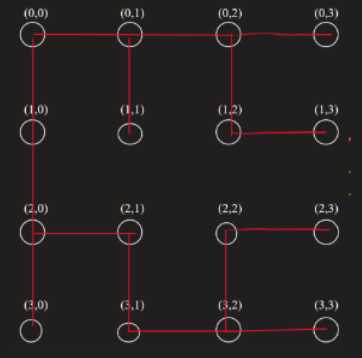

In [3]:
d = 2

shapes = {
    (0, 0): (2, 2, d),
    (0, 1): (2, 2, 2, d),
    (0, 2): (2, 2, 2, d),
    (0, 3): (2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, 2, d),
    (1, 3): (2, d),
    (2, 0): (2, 2, 2, d),
    (2, 1): (2, 2, d),
    (2, 2): (2, 2, d),
    (2, 3): (2, d),
    (3, 0): (2, d),
    (3, 1): (2, 2, d),
    (3, 2): (2, 2, 2, d),
    (3, 3): (2, d)
}

nodes = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(nodes[(0, 0)][0], nodes[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, d), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0)]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

# Initialize state

In [4]:
local_state = np.array([0,1])
ttn = ptn.uniform_product_state(ttn ,local_state, bond_dim= 2)

black_state = np.array([0,1])
white_state = np.array([1,0])
ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim = 2,  pattern = "checkerboard")

In [5]:
t = 2
u = 0.1
m = 0.5
Lx = 4
Ly = 4

H1 = ptn.BoseHubbard_ham(t, u, m, Lx, Ly, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

Correlation_function = ptn.Correlation_function("Site(0,0)", "Site(2,0)", 2)
Correlation_function = Correlation_function.pad_with_identities(ttn, symbolic= True)
Correlation_function = ptn.TTNO.from_hamiltonian(Correlation_function, ttn)

occupation_22 = ptn.Number_op_local("Site(2,2)", 2)
occupation_22 = occupation_22.pad_with_identities(ttn, symbolic= True)
occupation_22 = ptn.TTNO.from_hamiltonian(occupation_22, ttn)

I = ptn.TTNO.Identity(ttn)


In [27]:
lanczos_params =  {'N_min': 2,   
                   'N_max': 20,           
                   'P_tol': 1e-8,          
                   'reortho': True,}

expansion_params = {
                    "ExpansionMode": ptn.ExpansionMode.TTN,
                    "num_vecs": 3, 
                    "tau": 1e-2,
                    "SVDParameters": ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                    "InitExpST" : 0.1 , # first time to start the expansion 
                    "ConvThresh" : 0.007,
                    "ConvThreshUP" : 0.01,
                    "expansion_steps" : 20,
                    "tol": 1e-20,
                    "tol_step_increase": 10,
                    "tol_step_decrease": 0.5,
                    "max_bond": 170,
                    "rel_tot_bond": (5,20),
                    "T3N_dict" : {"Site(0,1)" : "Site(0,2)",
                                  "Site(0,2)" : "Site(0,3)",
                                  "Site(2,0)" : "Site(3,0)",
                                  "Site(3,2)" : "Site(3,3)"}}

config= ptn.TTNTimeEvolutionConfig(record_bond_dim = True,
                                   Lanczos_evolution= False,
                                   Lanczos_params = lanczos_params,
                                   Expansion_params = expansion_params)

tdvp = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.01,
                                 final_time = 2,
                                 operators = [Correlation_function , occupation_22],
                                 config = config)

In [28]:
tdvp.run_ex_partial_t3n(2)
times = tdvp.times()

 10%|▉         | 20/201 [00:02<00:21,  8.52it/s]

SVD MAX: 10
Initial tol: 1e-20
Phase 1 - Trial 1:
Expanded dim (26) > rel_tot_bond ((5, 20))
Increasing tol: 1e-19
Phase 1 - Trial 2:
Expanded dim (21) > rel_tot_bond ((5, 20))
Increasing tol: 1e-18


 11%|█         | 22/201 [00:03<00:55,  3.24it/s]

Acceptable expansion found in Phase 1: 8
expanded_dim T3NS: -10 : 115 ---> 105
expanded_dim TTN:  8 : 75 ---> 83


 20%|██        | 41/201 [00:05<00:17,  8.97it/s]

SVD MAX: 16
Initial tol: 1e-18
Phase 1 - Trial 1:
Expanded dim (72) > rel_tot_bond ((5, 20))
Increasing tol: 1e-17
Phase 1 - Trial 2:
Expanded dim (37) > rel_tot_bond ((5, 20))
Increasing tol: 1.0000000000000001e-16
Expanded dim became negative: 1
Switching to Phase 2
Phase 2 - Trial 1:
Decreasing tol: 5.0000000000000005e-17
Expanded_dim_tot: 4
Phase 2 - Trial 2:
Decreasing tol: 2.5000000000000003e-17


 21%|██        | 42/201 [00:09<02:04,  1.28it/s]

Expanded_dim_tot: 13
Acceptable expansion found in Phase 2: 13
expanded_dim T3NS: 13 : 111 ---> 124
expanded_dim TTN:  13 : 83 ---> 96


 31%|███       | 62/201 [00:13<00:36,  3.77it/s]

SVD MAX: 22
Initial tol: 2.5000000000000003e-17
Phase 1 - Trial 1:
Expanded dim (22) > rel_tot_bond ((5, 20))
Increasing tol: 2.5e-16
Expanded dim became negative: 0
Switching to Phase 2
Phase 2 - Trial 1:
Decreasing tol: 1.25e-16
Expanded_dim_tot: 1
Phase 2 - Trial 2:
Decreasing tol: 6.25e-17


 31%|███▏      | 63/201 [00:18<03:21,  1.46s/it]

Expanded_dim_tot: 6
Acceptable expansion found in Phase 2: 6
expanded_dim T3NS: 6 : 130 ---> 136
expanded_dim TTN:  6 : 96 ---> 102


 41%|████▏     | 83/201 [00:24<00:35,  3.28it/s]

SVD MAX: 22
Initial tol: 6.25e-17


 42%|████▏     | 84/201 [00:25<01:07,  1.74it/s]

Acceptable expansion found in initial attempt: 6
expanded_dim T3NS: 6 : 136 ---> 142
expanded_dim TTN:  6 : 102 ---> 108


 52%|█████▏    | 104/201 [00:32<00:33,  2.90it/s]

SVD MAX: 22
Initial tol: 6.25e-17
Phase 2 - Trial 1:
Decreasing tol: 3.125e-17


 52%|█████▏    | 105/201 [00:34<01:28,  1.09it/s]

Expanded_dim_tot: 17
Acceptable expansion found in Phase 2: 17
expanded_dim T3NS: 17 : 142 ---> 159
expanded_dim TTN:  17 : 108 ---> 125


 62%|██████▏   | 125/201 [00:46<00:44,  1.71it/s]

SVD MAX: 25
Initial tol: 3.125e-17


 63%|██████▎   | 126/201 [00:48<01:09,  1.07it/s]

Acceptable expansion found in initial attempt: 12
expanded_dim T3NS: 12 : 159 ---> 171
expanded_dim TTN:  12 : 125 ---> 137


 73%|███████▎  | 146/201 [01:05<00:47,  1.16it/s]

SVD MAX: 29
Initial tol: 3.125e-17


 73%|███████▎  | 147/201 [01:08<01:13,  1.36s/it]

Acceptable expansion found in initial attempt: 9
expanded_dim T3NS: 9 : 177 ---> 186
expanded_dim TTN:  9 : 137 ---> 146


 83%|████████▎ | 167/201 [01:31<00:39,  1.15s/it]

SVD MAX: 33
Initial tol: 3.125e-17


 84%|████████▎ | 168/201 [01:35<00:59,  1.82s/it]

Acceptable expansion found in initial attempt: 12
expanded_dim T3NS: 12 : 190 ---> 202
expanded_dim TTN:  12 : 146 ---> 158


 94%|█████████▎| 188/201 [02:06<00:20,  1.57s/it]

SVD MAX: 34
Initial tol: 3.125e-17


 94%|█████████▍| 189/201 [02:10<00:26,  2.24s/it]

Acceptable expansion found in initial attempt: 6
expanded_dim T3NS: 6 : 202 ---> 208
expanded_dim TTN:  6 : 158 ---> 164


100%|██████████| 201/201 [02:34<00:00,  1.30it/s]


c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


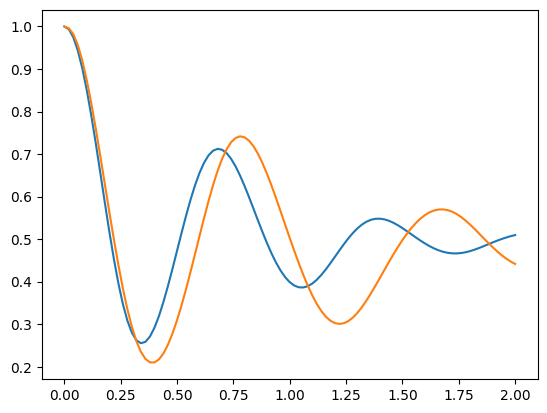

In [29]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)

plt.plot(times, oc_exact[:,2,2], label="exact")

plt.plot(times ,tdvp.operator_results()[1], label="exact")


In [ ]:
ptn.expectation_value(tdvp.accepted_states[2], tdvp.operators[0])

IndexError: list index out of range

In [ ]:
results = [ptn.expectation_value(state, occupation_22) for state in tdvp.accepted_states]

In [ ]:
tdvp

In [ ]:
plt.plot(results, label="exact")


In [ ]:
stop

In [ ]:
plt.plot(tdvp.convergence_list)

plt.title("")
plt.xlabel("Time")
plt.ylabel("convergence")
plt.legend()
plt.show()

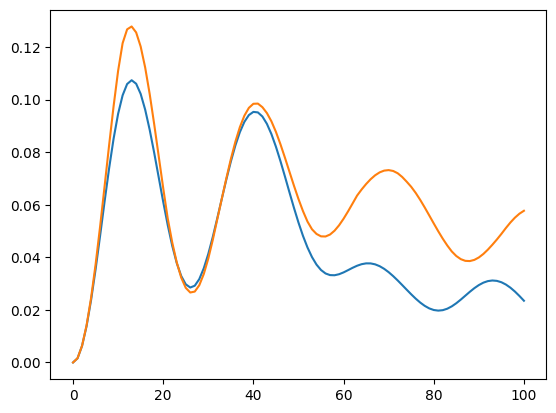

In [30]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (2,0),
                                                                     normalize = False)

oc_exact_00 = oc_exact[:,2,2]
plt.plot(correlation_exact, label="exact")
plt.plot(tdvp.operator_results()[0], label="exact")


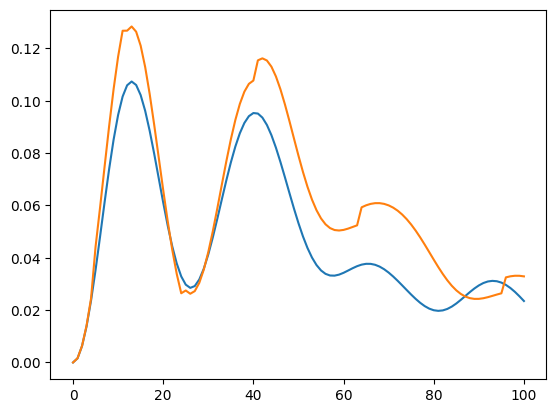

In [ ]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (2,0),
                                                                     normalize = False)

oc_exact_00 = oc_exact[:,2,2]
plt.plot(correlation_exact, label="exact")
plt.plot(tdvp.operator_results()[0], label="exact")


In [ ]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)
oc_exact_00 = oc_exact[:,2,2]
oc_tenpy, times = model.occupation_results(psi_list= psi_evolved, evaluation_time=2, dt = 0.01)
oc_tenpy = oc_tenpy[:,2,2]
oc_tdvp = tdvp.operator_results()[1]

plt.plot(times, abs(oc_tdvp - oc_exact_00) / oc_exact_00 , label="1tdvp - 2 min")
plt.plot(times, abs(oc_tenpy - oc_exact_00) / oc_exact_00 , label="tenpy - 5 min")
#plt.plot(times, oc_exact_00, label="exact")

plt.title("(0,0) occupation error")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()

In [ ]:
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=2,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (2,0),
                                                                     normalize = False)



plt.plot(times, abs(tdvp.operator_results()[0]), label="1tdvp - 2 min")
#plt.plot(times, correlation_tenpy, label="tenpy - 5 min")
plt.plot(times, correlation_exact, label="exact")

plt.title("(0,0)-(2,0) Correlation")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()